In [48]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from typing import List
%matplotlib inline

In [49]:
# загрузка датасета
import kagglehub

path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")

print("Путь:", path)

Путь: C:\Users\User\.cache\kagglehub\datasets\antonkozyriev\game-recommendations-on-steam\versions\28


In [50]:
rec_data = pd.read_csv(path + '\\recommendations.csv')
rec_data.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [51]:
rec_data.shape

(41154794, 8)

In [52]:
rec_data['user_id'].nunique() # уникальных пользователей

13781059

In [53]:
rec_data['app_id'].nunique() # уникальных игр

37610

Количество юзеров = 13M
Количество айтемов = 40к

Моя идея заключается в том, чтобы убрать большинство игр, для упрощения Item2Item матрицы.

Если взять, посчитанный в EDA Popular Bias, то можно заметить, что чуть более 95% отзывов приходится всего на 5000 игр

Я буду идти по накоплению коммулятивной суммы исходя из кол-ва отзывов у игр, из всего датасета с играми останется лишь 95% игр. Это ухудшит точность рекомендаций, но зато улучшит скорость алгоритма в 50 раз

Большинство игр лишатся рекомендаций, но на производительность алгоритма это окажет существенное ускорение

In [54]:
# датасет с играми
data_games = pd.read_csv(path + '\\games.csv') # 
data_games.describe()

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,5.087200e+04,50872.000000,5.087200e+04,50872.000000,50872.000000,50872.000000
mean,1.055224e+06,77.052033,1.824425e+03,8.620325,8.726788,5.592212
std,6.103249e+05,18.253592,4.007352e+04,11.514164,11.507021,18.606679
min,1.000000e+01,0.000000,1.000000e+01,0.000000,0.000000,0.000000
25%,5.287375e+05,67.000000,1.900000e+01,0.990000,0.990000,0.000000
50%,9.860850e+05,81.000000,4.900000e+01,4.990000,4.990000,0.000000
75%,1.524895e+06,91.000000,2.060000e+02,10.990000,11.990000,0.000000
max,2.599300e+06,100.000000,7.494460e+06,299.990000,299.990000,90.000000


In [55]:
g = (rec_data.groupby("app_id")["app_id"]
     .count()
     .rename("count")
     .sort_values(ascending=False)
     .reset_index())

# Вычисление накопленной суммы и пропорции
g["cumsum"] = g["count"].cumsum()
g["proportion"] = g["cumsum"] / g["count"].sum()

In [56]:
g

,app_id,count,cumsum,proportion
0,440,319492,319492,0.007763
1,252490,270684,590176,0.014340
2,1091500,226414,816590,0.019842
3,730,219737,1036327,0.025181
4,570,216914,1253241,0.030452
...,...,...,...,...
37605,1899980,1,41154790,1.000000
37606,1448970,1,41154791,1.000000
37607,1236960,1,41154792,1.000000
37608,1634450,1,41154793,1.000000


In [57]:
total_count = g["count"].sum()

THRESHOLD = 0.95
threshold_count = total_count * THRESHOLD

top_95_games = g[g["cumsum"] <= threshold_count]["app_id"].tolist()

print(f"Количество игр, покрывающих 90% взаимодействий: {len(top_95_games)}")
print(f"Они дают {g.loc[len(top_95_games)-1, 'cumsum']/total_count*100:.1f}% взаимодействий")

Количество игр, покрывающих 90% взаимодействий: 5945
Они дают 95.0% взаимодействий


In [58]:
top_95_games[-1]

726830

In [59]:
data_games[data_games['app_id'] == top_95_games[-1]]

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
6044,726830,Vacation Simulator,2019-04-09,True,False,False,Very Positive,92,735,29.99,29.99,0.0,True


Последняя игра имеет 735 отзывов

# Метрики

In [60]:
def ndcg_metric(gt_items, predicted):
    
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)


def recall_metric(gt_items, predicted):
    
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt



def evaluate_recommender(df, model_preds, gt_col='test_interactions', topn=100):
    
    metric_values = []
    
    for  row in df.iter_rows(named=True):
        gt_items = [x['app_id'] for x in row[gt_col]]
        metric_values.append((ndcg_metric(gt_items, row[model_preds][:topn]),
                              recall_metric(gt_items, row[model_preds][:topn])))
        
    return {'ndcg':np.mean([x[0] for x in metric_values]),
            'recall':np.mean([x[1] for x in metric_values])}

import polars as pl

def get_metrics(df: pl.DataFrame, model_preds_col: str, gt_col='test_interactions', topn=10):
    """
    df: Polars DataFrame с колонками:
        - gt_col: список кортежей (item_id, timestamp)
        - model_preds_col: список item_id предсказаний
    Возвращает: список кортежей (ndcg, recall) для каждой строки
    """

    def row_metrics(gt_list, pred_list):
        # gt_list — список структур Polars, нужно взять только item_id
        gt_items = [x[gt_col_name] if isinstance(x, dict) else x[0] for x in gt_list]
        return (ndcg_metric(gt_items, pred_list),
                recall_metric(gt_items, pred_list))

    gt_col_name = gt_col  # для обращения к полям struct

    # Полярс Apply через Struct или List
    result = df.with_columns(
        pl.struct([pl.col(gt_col), pl.col(model_preds_col)])
          .apply(lambda x: row_metrics(x[gt_col], x[model_preds_col]))
          .alias("metrics")
    )

    return result["metrics"].to_list()

# Предобработка

In [61]:
import polars as pl
import matplotlib.pyplot as plt

In [62]:
rec_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


In [63]:
rec_data['date'] = pd.to_datetime(rec_data['date'])

print(rec_data['date'].dtype)
rec_data.head()

datetime64[ns]


,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [64]:
rec_data.isna().sum()

app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64

In [65]:
rec_data = rec_data.drop(columns=['helpful', 'funny', 'hours', 'review_id'])
rec_data.head()

,app_id,date,is_recommended,user_id
0,975370,2022-12-12,True,51580
1,304390,2017-02-17,False,2586
2,1085660,2019-11-17,True,253880
3,703080,2022-09-23,True,259432
4,526870,2021-01-10,True,23869


In [66]:
rec_data_filtered = rec_data[rec_data['app_id'].isin(top_95_games)]
rec_data_filtered.shape

(39097013, 4)

In [67]:
df = pl.from_pandas(rec_data_filtered)
df

app_id,date,is_recommended,user_id
i64,datetime[ns],bool,i64
975370,2022-12-12 00:00:00,true,51580
304390,2017-02-17 00:00:00,false,2586
1085660,2019-11-17 00:00:00,true,253880
703080,2022-09-23 00:00:00,true,259432
526870,2021-01-10 00:00:00,true,23869
…,…,…,…
633230,2021-02-15 00:00:00,true,1606890
758870,2019-07-18 00:00:00,false,1786254
696170,2018-03-26 00:00:00,false,6370324


C:\Users\User\AppData\Local\Temp\ipykernel_3744\1808831686.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  popular_items = df.group_by("app_id").agg(pl.count()).sort("count", descending=True)


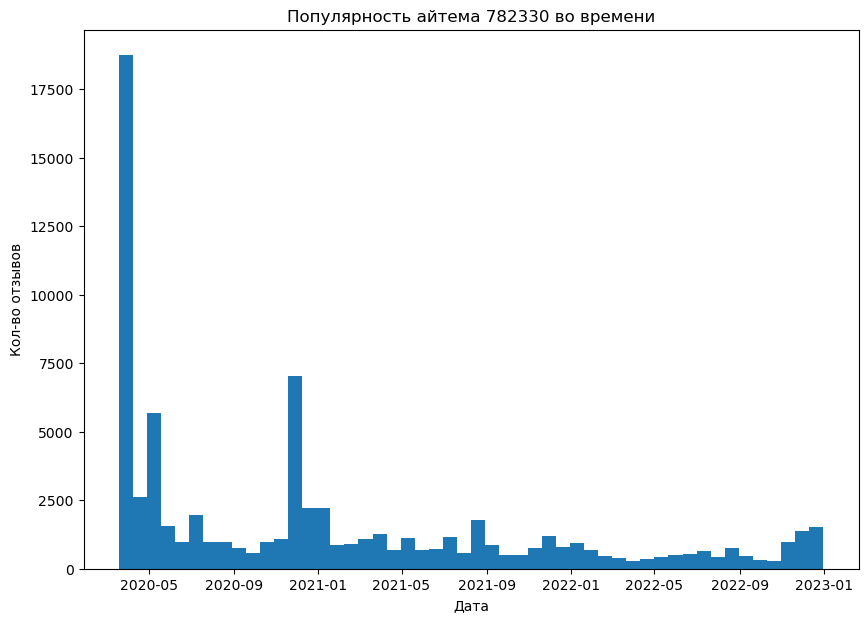

In [68]:
# 1. Топ-300 популярных item_id
popular_items = df.group_by("app_id").agg(pl.count()).sort("count", descending=True)
popular_items = popular_items["app_id"][:300].to_list()

# 2. Случайный выбор
sampled_id = np.random.choice(popular_items)

# 3. Выборка взаимодействий для выбранного item
interactions = df.filter(pl.col("app_id") == sampled_id)

# 4. Визуализация гистограммы last_watch_dt
fig = plt.figure(figsize=(10, 7))
plt.title(f'Популярность айтема {sampled_id} во времени')
plt.hist(interactions["date"].to_numpy(), bins=50)
plt.xlabel("Дата")
plt.ylabel("Кол-во отзывов")
plt.show()

In [69]:
# 1. Максимальная дата last_watch_dt для каждого app_id
temp = (
    df.group_by("app_id")
      .agg(pl.col("date").max().alias("date"))
)

# 2. Оставляем только популярные app_id
temp = temp.filter(pl.col("app_id").is_in(popular_items))

# 3. Сортировка по last_watch_dt
temp = temp.sort("date")

# 4. Просмотр первых строк
print(temp.head(10))

shape: (10, 2)
┌─────────┬─────────────────────┐
│ app_id  ┆ date                │
│ ---     ┆ ---                 │
│ i64     ┆ datetime[ns]        │
╞═════════╪═════════════════════╡
│ 489520  ┆ 2022-12-30 00:00:00 │
│ 1238840 ┆ 2022-12-31 00:00:00 │
│ 322330  ┆ 2022-12-31 00:00:00 │
│ 238960  ┆ 2022-12-31 00:00:00 │
│ 365590  ┆ 2022-12-31 00:00:00 │
│ 393380  ┆ 2022-12-31 00:00:00 │
│ 307780  ┆ 2022-12-31 00:00:00 │
│ 376210  ┆ 2022-12-31 00:00:00 │
│ 683320  ┆ 2022-12-31 00:00:00 │
│ 391540  ┆ 2022-12-31 00:00:00 │
└─────────┴─────────────────────┘


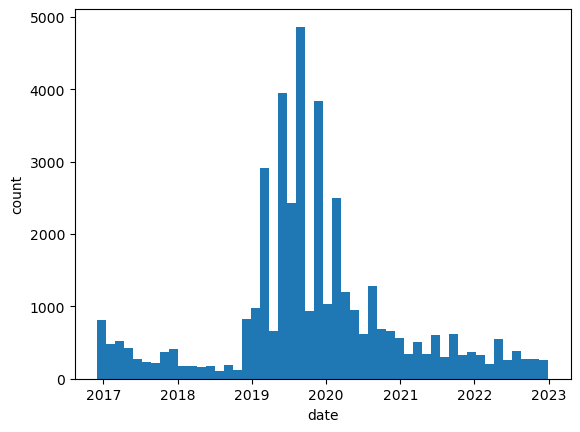

In [70]:
# interactions = df.loc[df.item_id==7107].copy()
# interactions.last_watch_dt.hist()

temp = df.filter(pl.col('app_id') == 489520)


# 4. Визуализация гистограммы last_watch_dt
plt.hist(temp["date"].to_numpy(), bins=50)
plt.xlabel("date")
plt.ylabel("count")
plt.show()

## Объединение датасетов

In [71]:
df = df.with_columns(
    pl.col('date').dt.timestamp('ms').alias('timestamp_ms')
)

df

app_id,date,is_recommended,user_id,timestamp_ms
i64,datetime[ns],bool,i64,i64
975370,2022-12-12 00:00:00,true,51580,1670803200000
304390,2017-02-17 00:00:00,false,2586,1487289600000
1085660,2019-11-17 00:00:00,true,253880,1573948800000
703080,2022-09-23 00:00:00,true,259432,1663891200000
526870,2021-01-10 00:00:00,true,23869,1610236800000
…,…,…,…,…
633230,2021-02-15 00:00:00,true,1606890,1613347200000
758870,2019-07-18 00:00:00,false,1786254,1563408000000
696170,2018-03-26 00:00:00,false,6370324,1522022400000


Будем обучаться на выборке до последних двух месяцев, тестироваться на выборке за последние 2 месяца

In [72]:
max_timestamp = df['timestamp_ms'].max() # Последняя дата
max_timestamp

1672444800000

In [73]:
DATE_THRESHOLD = max_timestamp - 1000 * 2 * 24 * 60 * 60 # порог для разбиения выборки
DATE_THRESHOLD

1672272000000

In [74]:
train_df = df.filter(pl.col("timestamp_ms") < DATE_THRESHOLD)
test_df = df.filter(pl.col("timestamp_ms") >= DATE_THRESHOLD)

train_users = train_df.select(pl.col("user_id").unique()).to_numpy().flatten()
test_users = test_df.select(pl.col("user_id").unique()).to_numpy().flatten()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  66383
число людей всего: 13589497


In [75]:
len(set(test_users) - set(train_users)) / len(test_users) # Тестовая часть = 33%

0.3362098274103554

In [76]:
n_users = 40000
all_included = pl.Series(np.random.choice(all_included, size=n_users, replace=False))

train_df = train_df.filter(pl.col("user_id").is_in(pl.Series(all_included).implode()))
test_df = test_df.filter(pl.col("user_id").is_in(pl.Series(all_included).implode()))

assert train_df.select(pl.col("timestamp_ms").max()).item() < test_df.select(pl.col("timestamp_ms").min()).item()
assert train_df.select(pl.col("user_id").n_unique()).item() == n_users
assert test_df.select(pl.col("user_id").n_unique()).item() == n_users

In [77]:
train_df.head()

app_id,date,is_recommended,user_id,timestamp_ms
i64,datetime[ns],bool,i64,i64
1172470,2021-01-09 00:00:00,true,1194057,1610150400000
275850,2016-08-13 00:00:00,true,6243103,1471046400000
620980,2021-06-17 00:00:00,true,5843184,1623888000000
534380,2022-11-22 00:00:00,true,4513609,1669075200000
284160,2022-03-20 00:00:00,true,6048548,1647734400000


In [78]:
# Функция для группировки и сортировки
def group_interactions(df, item_col="app_id", time_col="timestamp_ms"):
    return (
        df.sort([pl.col("user_id"), pl.col(time_col)])  # сначала сортируем по пользователю и времени
          .group_by("user_id")
          .agg(
              pl.struct([pl.col(item_col), pl.col(time_col)]).alias("interactions")
          )
    )

train_grouped = group_interactions(train_df).rename({"interactions": "train_interactions"})
test_grouped = group_interactions(test_df).rename({"interactions": "test_interactions"})

train_grouped.head()

user_id,train_interactions
i64,list[struct[2]]
113,"[{597760,1641600000000}, {218640,1646352000000}]"
415,"[{284160,1580601600000}, {387990,1589846400000}, … {242760,1660608000000}]"
925,"[{252490,1634256000000}]"
960,"[{648800,1667174400000}, {427730,1668643200000}]"
1158,"[{1259420,1628985600000}, {633230,1632355200000}, {677620,1636848000000}]"


In [79]:
joined = train_grouped.join(test_grouped, on=['user_id'])
joined.head()

user_id,train_interactions,test_interactions
i64,list[struct[2]],list[struct[2]]
113,"[{597760,1641600000000}, {218640,1646352000000}]","[{220,1672272000000}]"
415,"[{284160,1580601600000}, {387990,1589846400000}, … {242760,1660608000000}]","[{292030,1672358400000}]"
925,"[{252490,1634256000000}]","[{242760,1672358400000}]"
960,"[{648800,1667174400000}, {427730,1668643200000}]","[{1172620,1672358400000}]"
1158,"[{1259420,1628985600000}, {633230,1632355200000}, {677620,1636848000000}]","[{346110,1672358400000}]"


# Baseline (TopPopular)

In [80]:
from typing import List
import polars as pl
import numpy as np


class TopPopular:

    def __init__(self):
        self.trained = False
        self.recommendations = None

    def fit(self, df: pl.DataFrame, col: str = "train_interactions"):
        """
        df[col] : List[Struct[item_id, last_watch_dt]]
        """

        counts = (
            df
            .select(pl.col(col))
            .explode(col)                                # -> Struct(item_id, last_watch_dt)
            .select(pl.col(col).struct.field("app_id"))
            .group_by("app_id")
            .count()
            .sort("count", descending=True)
        )

        self.recommendations = counts["app_id"].to_list()
        self.trained = True

    def predict(self, df: pl.DataFrame, topn: int = 300) -> List[np.ndarray]:
        assert self.trained
        recs = np.array(self.recommendations[:topn])
        return [recs] * len(df)
    

toppop = TopPopular()
toppop.fit(joined)

joined = joined.with_columns(
    pl.Series(
        name="toppopular_recs",
        values=toppop.predict(joined)
    )
)

joined.head()

C:\Users\User\AppData\Local\Temp\ipykernel_3744\2785781161.py:23: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


user_id,train_interactions,test_interactions,toppopular_recs
i64,list[struct[2]],list[struct[2]],"array[i32, 300]"
113,"[{597760,1641600000000}, {218640,1646352000000}]","[{220,1672272000000}]","[440, 1091500, … 646910]"
415,"[{284160,1580601600000}, {387990,1589846400000}, … {242760,1660608000000}]","[{292030,1672358400000}]","[440, 1091500, … 646910]"
925,"[{252490,1634256000000}]","[{242760,1672358400000}]","[440, 1091500, … 646910]"
960,"[{648800,1667174400000}, {427730,1668643200000}]","[{1172620,1672358400000}]","[440, 1091500, … 646910]"
1158,"[{1259420,1628985600000}, {633230,1632355200000}, {677620,1636848000000}]","[{346110,1672358400000}]","[440, 1091500, … 646910]"


In [81]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'ndcg': 0.3165457692700104, 'recall': 0.3062424302069972}

# EASE

In [82]:
item_counts = train_df.group_by(['app_id']).agg(pl.col('user_id').len()).sort(by='user_id', descending=True)
item_counts = item_counts[:5000]
item_counts.head()

app_id,user_id
i64,u32
440,2603
1091500,2008
550,1797
377160,1631
945360,1601


In [83]:
print(train_df.shape)
train_df = train_df.join(item_counts, on='app_id', how='inner')
print(train_df.shape)

(425635, 5)
(419507, 6)


In [84]:
import polars as pl


# item_id ↔ id
item2id = {k: v for v, k in enumerate(train_df["app_id"].unique())}
id2item = {v: k for k, v in item2id.items()}

# user_id ↔ id
user2id = {k: v for v, k in enumerate(train_df["user_id"].unique())}
id2user = {v: k for k, v in user2id.items()}

# замена значений
train_df = train_df.with_columns(
    pl.col("user_id").replace(user2id),
    pl.col("app_id").replace(item2id),
)

train_df.sample(5)

app_id,date,is_recommended,user_id,timestamp_ms,user_id_right
i64,datetime[ns],bool,i64,i64,u32
1812,2016-08-18 00:00:00,true,23807,1471478400000,368
1217,2020-09-22 00:00:00,true,36170,1600732800000,947
447,2021-05-09 00:00:00,true,1156,1620518400000,869
1700,2016-08-08 00:00:00,true,33445,1470614400000,274
3992,2020-08-07 00:00:00,true,19217,1596758400000,615


In [85]:
train_df = train_df[['user_id','app_id']].unique()

In [86]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(train_df.shape[0]), (train_df['user_id'], train_df['app_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 419506 stored elements and shape (39920, 5000)>

In [87]:
%%time

def fit_ease(X, reg_weight=100):
    
    # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix)

CPU times: total: 10.4 s
Wall time: 1.3 s


In [88]:
w = w / np.linalg.norm(w, axis=1, keepdims=True)  # L2-нормализация строк

In [89]:
w.shape

(5000, 5000)

In [90]:
print(joined['train_interactions'].head(1))  # Должен быть список структур

shape: (1,)
Series: 'train_interactions' [list[struct[2]]]
[
	[{597760,1641600000000}, {218640,1646352000000}]
]


In [93]:
def get_preds_polars(x, item2id, id2item, w, topk=100):
    # x — список структур Polars: [{"app_id": 123, "timestamp_ms": ...}, ...]
    user_items = [item['app_id'] for item in x]  # Извлекаем app_id как числа
    
    # Кодируем item_id в индексы
    encoded = [item2id[item_id] for item_id in user_items if item_id in item2id]
    
    if not encoded:  # Если нет валидных item_id
        return []

    # Создаём бинарный вектор взаимодействий
    vector = np.zeros(len(item2id), dtype=np.float32)
    vector[encoded] = 1.0
    vector = sps.csr_matrix(vector)

    # Получаем предсказания
    preds = np.asarray(vector.dot(w)).ravel()

    # Маскируем уже просмотренные item_id
    preds[encoded] = -np.inf

    # Сортируем по убыванию и берём топ-k
    ranks = np.argsort(-preds)[:topk]

    return [id2item[i] for i in ranks]

import polars as pl

out = []
for x in joined["train_interactions"]:
    out.append(get_preds_polars(x, item2id, id2item, w))

joined = joined.with_columns(pl.Series(out).alias('ease_preds'))
joined.head()


user_id,train_interactions,test_interactions,toppopular_recs,ease_preds
i64,list[struct[2]],list[struct[2]],"array[i32, 300]",list[i64]
113,"[{597760,1641600000000}, {218640,1646352000000}]","[{220,1672272000000}]","[440, 1091500, … 646910]","[440880, 238320, … 704850]"
415,"[{284160,1580601600000}, {387990,1589846400000}, … {242760,1660608000000}]","[{292030,1672358400000}]","[440, 1091500, … 646910]","[526870, 1174180, … 291550]"
925,"[{252490,1634256000000}]","[{242760,1672358400000}]","[440, 1091500, … 646910]","[1172470, 1938090, … 1599340]"
960,"[{648800,1667174400000}, {427730,1668643200000}]","[{1172620,1672358400000}]","[440, 1091500, … 646910]","[242760, 674940, … 728880]"
1158,"[{1259420,1628985600000}, {633230,1632355200000}, {677620,1636848000000}]","[{346110,1672358400000}]","[440, 1091500, … 646910]","[1593500, 349040, … 646910]"


In [94]:
evaluate_recommender(joined, model_preds='ease_preds') # lambda 100

{'ndcg': 0.3779078006341014, 'recall': 0.36636525413403687}

In [95]:
evaluate_recommender(joined, model_preds='toppopular_recs') # lambda 100

{'ndcg': 0.3165457692700104, 'recall': 0.3062424302069972}

In [ ]:
joined